In [9]:
#####################################################################################################
#####################################################################################################
####################### Import dependencies
#####################################################################################################
#####################################################################################################

import bovespa
import pandas as pd
import csv
import fnmatch
import re
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
from os import listdir, path
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from pandasql import sqldf

In [34]:
#####################################################################################################
#####################################################################################################
####################### Define constants and classes
#####################################################################################################
#####################################################################################################

# Constants
CONST_directory                            = "../data"
CONST_fdata_regex                          = "*.txt"
CONST_fcodes_not_regex                     = "\d\w|\d\d"
CONST_fcodes_regex                         = "^\w\w\w\w\d$"
CONST_ma_days                              = 21
CONST_sdv_times                            = 2
CONST_operation_start_days                 = 1
CONST_stop_buy                             = 0.1
CONST_comission                            = 5.0
CONST_amount                               = 20000.0
CONST_fig_x                                = 20
CONST_fig_y                                = 8

CONST_formula_label                        = "FORMULA"
CONST_date_label                           = "DATE"
CONST_ratio_label                          = "RATIO"
CONST_price_label                          = "PRICE"
CONST_cumulative_suffix_label              = "_CUMULATIVE"
CONST_buydate_label                        = "Buy Date:"
CONST_selldate_label                       = "Sell Date:"
CONST_file_label                           = "Arquivo:" 
CONST_stock1_label                         = "Stock 1:"
CONST_stock2_label                         = "Stock 2:"
CONST_operation_label                      = "Operation"
CONST_bbands_upper_label                   = "BBANDS_UPPER"
CONST_bbands_middleupper_label             = "BBANDS_MIDDLEUPPER"
CONST_bbands_base_label                    = "BBANDS_BASE"
CONST_bbands_middlelower_label             = "BBANDS_MIDDLELOWER"
CONST_bbands_lower_label                   = "BBANDS_LOWER"
CONST_bbands_trend_label                   = "BBANDS_TREND"
CONST_bbands_result_label                  = "BBANDS_TREND_PRICE"
CONST_bbands_cost_label                    = "BBANDS_COST"
CONST_revenue_prefix_label                 = "STOCK_REVENUE_"
CONST_cost_prefix_label                    = "STOCK_COST_"
CONST_result_prefix_label                  = "STOCK_RESULT_" 
CONST_gain_prefix_label                    = "STOCK_GAIN_"
CONST_stocks_prefix_label                  = "STOCK_QUANTITY_"
CONST_netincome_ratio_value_label          = "NETINCOME_VALUE_RATIO"
CONST_netincome_ratio_percent_label        = "NETINCOME_PERCENT_RATIO"

pysqldf = lambda q: sqldf(q, globals())

In [77]:
#####################################################################################################
#####################################################################################################
####################### Define constants and classes
#####################################################################################################
#####################################################################################################

# Classes
class Indicator:
    @classmethod
    def revenue(self, df, date_attr, price_attr, **kwargs):
        buy_date = (kwargs.get("buy_date") or df[date_attr][0])
        sell_date = (kwargs.get("sell_date") or df[date_attr][df[date_attr].size - 1])
        initial_amount = (kwargs.get("amount") or 10000.0)
        comission = (kwargs.get("comission") or 5.0)
        lot_size = (kwargs.get("lot_size") or 100)
        stop = (kwargs.get("stop") or None)
        start = (kwargs.get("start") or None)
        
        Revenue = pd.Series(None, index = df.index, name = (kwargs.get("revenue_name") or "REVENUE_NAME"))
        Result = pd.Series(None, index = df.index, name = (kwargs.get("result_name") or "RESULT_NAME"))
        Cost = pd.Series(None, index = df.index, name = (kwargs.get("cost_name") or "COST_NAME"))
        Stocks = pd.Series(0, index = df.index, name = (kwargs.get("stocks_name") or "STOCKS_NAME"))
        
        # Calculate first investment
        buy_line     = df[df[date_attr] == buy_date]
        lot_price    = (buy_line[price_attr]).item() * lot_size
        lot_qtd      = math.floor(initial_amount / lot_price)
        amount       = initial_amount - (lot_price * lot_qtd)
        idx          = buy_line.index.item()
        
        Stocks[idx]  = lot_qtd * lot_size
        Revenue[idx] = 0.0
        Cost[idx]    = -(comission + (lot_price * lot_qtd))
        Result[idx]  = amount + Cost[idx].item() + (lot_price * lot_qtd)
        
        for idx, value in df[np.logical_and(df[date_attr] > buy_date, df[date_attr] <= sell_date)].iterrows():
            previous_price     = (df.loc[idx-1][price_attr]).item()
            lot_price          = value[price_attr] * lot_size
            stocks             = Stocks[idx-1].item()
            Revenue[idx]       = (value[price_attr] - previous_price) * stocks
            result             = Result[idx-1].item() + Revenue[idx].item()            
            cost               = 0.0
            qtd_buy_sell       = 0
              
            # Buy more or close position
            if value[date_attr] == sell_date:
                cost += (stocks * value[price_attr]) - comission 
                stocks = 0
                lot_qtd = 0
                
            elif start and result >= (start * initial_amount) and result >= lot_price:
                qtd_buy_sell = math.floor(result / lot_price)
                amount       = result - (lot_price * qtd_buy_sell)
                lot_qtd      = lot_qtd + qtd_buy_sell
                cost        -= comission + (lot_price * qtd_buy_sell)
            
            Result[idx] = result + cost
            Cost[idx]   = cost
            Stocks[idx] = lot_size * lot_qtd
            
        return pd.concat([df[date_attr], Result, Revenue, Cost, Stocks], join='outer', axis=1)
    
    @classmethod
    def revenue_with_ratio(self, df, date_attr, stock1_price_attr, stock2_price_attr, bb_ratio_attr, bb_base_attr, bb_trend_attr, **kwargs):
        buy_date = (kwargs.get("buy_date") or df[date_attr][0])
        sell_date = (kwargs.get("sell_date") or df[date_attr][df[date_attr].size - 1])
        initial_amount = (kwargs.get("amount") or 10000.0)
        comission = (kwargs.get("comission") or 5.0)
        lot_size = (kwargs.get("lot_size") or 100)
        stop = (kwargs.get("stop") or None)
        start = (kwargs.get("start") or None)
        
        Revenue = pd.Series(None, index = df.index, name = (kwargs.get("revenue_name") or "REVENUE_NAME"))
        Result = pd.Series(None, index = df.index, name = (kwargs.get("result_name") or "RESULT_NAME"))
        Cost = pd.Series(None, index = df.index, name = (kwargs.get("cost_name") or "COST_NAME"))
        Stocks = pd.Series(0, index = df.index, name = (kwargs.get("stocks_name") or "STOCKS_NAME"))
        
        # It defines the first buy of stock for net income calculation
        buy_line  = df[df[date_attr] == buy_date]
        
        if (buy_line[bb_base_attr]).item() and ((buy_line[bb_ratio_attr]).item() > (buy_line[bb_base_attr]).item()):
            trend = 1
        else:
            trend = -1
        
        price_attr = stock1_price_attr if trend == -1 else stock2_price_attr
        
        # Calculate first investment
        lot_price    = (buy_line[price_attr]).item() * lot_size
        lot_qtd      = math.floor(initial_amount / lot_price)
        amount       = initial_amount - (lot_price * lot_qtd)
        idx          = buy_line.index.item()
        
        Stocks[idx]  = lot_qtd * lot_size
        Revenue[idx] = 0.0
        Cost[idx]    = -(comission + (lot_price * lot_qtd))
        Result[idx]  = amount + Cost[idx].item() + (lot_price * lot_qtd)
        
        print("IDX", "\tQTD", "\tS", "\tR$", "\tEXEC")
        print(idx, (lot_qtd * lot_size), price_attr, (lot_price/lot_size), "Buy")
        print(idx, Stocks[idx].item(), price_attr, (lot_price/lot_size), Result[idx].item(), Cost[idx].item(), "Result")          
        
        for idx, value in df[np.logical_and(df[date_attr] > buy_date, df[date_attr] <= sell_date)].iterrows():
            previous_price     = (df.loc[idx-1][price_attr]).item()
            lot_price          = value[price_attr] * lot_size
            stocks             = Stocks[idx-1].item()
            Revenue[idx]       = (value[price_attr] - previous_price) * stocks
            result             = Result[idx-1].item() + Revenue[idx].item()            
            cost               = 0.0
            qtd_buy_sell       = 0
              
            # Change, buy more or close position
            if value[date_attr] == sell_date:
                cost += (stocks * value[price_attr]) - comission 
                stocks = 0
                lot_qtd = 0
                print(idx, (lot_qtd*lot_size), price_attr, (lot_price/lot_size), "Sell all")

            elif (value[bb_trend_attr] == 1 and trend == -1) or (value[bb_trend_attr] == -1 and trend == 1):
                trend = 1 if trend == -1 else -1
                price_attr = stock2_price_attr if trend == 1 else stock1_price_attr
                
                temp_cost      = cost + (lot_price * lot_qtd) - comission
                temp_result    = result + temp_cost
                temp_lot_price = value[price_attr] * lot_size
                temp_lot_qtd   = math.floor(temp_result / temp_lot_price)
                
                # Can sell and buy?
                if (temp_lot_qtd > 0):
                    # Sell
                    cost    = temp_cost
                    result  = temp_result
                    stocks  = 0
                    lot_qtd = 0
                    print("CHANGE:", trend, price_attr, lot_size, lot_qtd, cost, result)                
                    print(idx, (lot_qtd * lot_size), price_attr, (lot_price/lot_size), "Sell")

                    # Buy
                    lot_price = temp_lot_price
                    lot_qtd   = temp_lot_qtd
                    amount    = result - (lot_price * lot_qtd)
                    prev_cost = cost
                    cost      -= comission + (lot_price * lot_qtd)
                    result    = amount - prev_cost + (lot_price * lot_qtd)
                    print("CHANGE:", trend, price_attr, lot_size, lot_qtd, cost, result)                  
                    print(idx, (lot_size * lot_qtd), price_attr, (lot_price/lot_size), "Buy")                
                
            elif start and result >= (start * initial_amount) and result >= lot_price:
                qtd_buy_sell = math.floor(result / lot_price)
                amount       = result - (lot_price * qtd_buy_sell)
                lot_qtd      = lot_qtd + qtd_buy_sell
                cost        -= comission + (lot_price * qtd_buy_sell)
                print(idx, (lot_size * lot_qtd), price_attr, (lot_price/lot_size), "Buy")                  
            
            Result[idx] = result + cost
            Cost[idx]   = cost
            Stocks[idx] = lot_size * lot_qtd
            print(idx, Stocks[idx].item(), price_attr, (lot_price/lot_size), Result[idx].item(), Cost[idx].item(), "Result")  

        return pd.concat([df[date_attr], Result, Revenue, Cost, Stocks], join='outer', axis=1)
            
    @classmethod
    def bbands(self, df, date_attr, price_attr, n, nstd, nresult, **kwargs):
        buy_date = (kwargs.get("buy_date") or df[date_attr][0])
        sell_date = (kwargs.get("sell_date") or df[date_attr][df[date_attr].size - 1])
        comission = (kwargs.get("comission") or 5.0)
        
        MA = pd.Series(df[price_attr].rolling(window=n).mean())
        MSD = pd.Series(df[price_attr].rolling(window=n).std())
        
        Base = pd.Series(MA, name = (kwargs.get("base_name") or "BASE"))
        Middle_upper = pd.Series(MA + MSD * nstd/2, name = (kwargs.get("middle_upper_name") or "MIDDLE_UPPER"))
        Middle_lower = pd.Series(MA - MSD * nstd/2, name = (kwargs.get("middle_lower_name") or "MIDDLE_LOWER"))
        Upper = pd.Series(MA + MSD * nstd, name = (kwargs.get("upper_name") or "UPPER"))
        Lower = pd.Series(MA - MSD * nstd, name = (kwargs.get("lower_name") or "LOWER"))        
        
        Cost = pd.Series(0, index = Lower.index, name = (kwargs.get("cost_name") or "COST"))
        Trend = pd.Series(0, index = Lower.index, name = (kwargs.get("trend_name") or "TREND"))
        Result = pd.Series(None, index = Lower.index, name = (kwargs.get("result_name") or "RESULT"))
        
        last_result = None
        last_idx = 0
        last_trend = None
        
        for idx, value in df[np.logical_and(df[date_attr] > buy_date, df[date_attr] <= sell_date)].iterrows():
            if idx >= n:
                # Trend/Result calculation
                if ((last_trend != 1) and 
                        ((df[price_attr][idx] > Upper[idx]) or 
                        ((last_trend != 1) and ((idx - last_idx) >= nresult) and (df[price_attr][idx] > Middle_upper[idx])) or
                        ((last_trend != 1) and ((idx - last_idx) >= 2*nresult) and (df[price_attr][idx] > Base[idx])))):
                    Trend[idx] = 1
                elif ((last_trend != -1) and 
                        ((df[price_attr][idx] < Lower[idx]) or 
                        ((last_trend != -1) and ((idx - last_idx) >= nresult) and (df[price_attr][idx] < Middle_lower[idx])) or
                        ((last_trend != -1) and ((idx - last_idx) >= 2*nresult) and (df[price_attr][idx] < Base[idx])))):
                    Trend[idx] = -1                                   
                    
                # Lower/Upper adjust based on trend    
                if (Trend[idx] == 1) and (Lower[idx] < Lower[idx-1]):
                    Lower[idx] = Lower[idx-1]
                elif (Trend[idx] == -1) and (Upper[idx] > Upper[idx-1]):
                    Upper[idx] = Upper[idx-1]
                
                # Update result
                if (Trend[idx] != 0):
                    Result[idx] = df[price_attr][idx]
                    Cost[idx] = -2 * comission 
                    last_result = Result[idx]
                    last_idx = idx
                    last_trend = Trend[idx]                    
                    
        return pd.concat([df[date_attr], Upper, Middle_upper, Base, Middle_lower, Lower, Result, Trend, Cost], join='outer', axis=1)

class Parser:
    def __init__(self, inpt, output=None):
        self.input = inpt
        self.output = output

    @classmethod
    def convert_record_to_dict(self, query):
        for rec in query:
            yield rec.info

    def get_query(self):
        bf = bovespa.File(self.input)
        return bf.query()

    def get_dataframe(self):
        return pd.DataFrame(self.convert_record_to_dict(self.get_query()))
    
class Select:
    def __init__(self, option=None, dropdown=None):
        self.option = option
        self.dropdown = dropdown
        
    def get_dropdown(self, options, description="Option:"):
        if not self.dropdown:
            w = widgets.Dropdown(options=options,description=description,value=options[0])
            w.observe(self.on_change)
            self.dropdown = w
            self.option = w.value
        
        return self.dropdown
    
    def on_change(self, change):      
        if change.name == "value" and change.type == "change":
            self.option = change.new    
            
class Reader(Select):
    @classmethod
    def get_files(self, where, regex):
        return sorted([name for name in listdir(where) if re.compile(fnmatch.translate(regex), re.IGNORECASE).match(name)])

In [4]:
#####################################################################################################
#####################################################################################################
####################### Select Bovespa file
#####################################################################################################
#####################################################################################################

file = Select()
display(file.get_dropdown(Reader.get_files(CONST_directory, CONST_fdata_regex), CONST_file_label))

Dropdown(description='Arquivo:', options=('COTAHIST_A2005.TXT', 'COTAHIST_A2006.TXT', 'COTAHIST_A2007.TXT', 'C…

In [5]:
#####################################################################################################
#####################################################################################################
####################### Parse Bovespa file
#####################################################################################################
#####################################################################################################

p = Parser(path.join(CONST_directory, file.option))
d = p.get_dataframe()

codes = d.CODNEG
options = codes[
    np.logical_and(
        ~codes.str.contains(CONST_fcodes_not_regex),
        codes.str.contains(CONST_fcodes_regex)
    )].sort_values().unique()

stock1 = Select()
stock2 = Select()

display(stock1.get_dropdown(options, CONST_stock1_label))
display(stock2.get_dropdown(options, CONST_stock2_label))

Dropdown(description='Stock 1:', options=('ABCB4', 'ABNB3', 'ABYA3', 'ACES3', 'ACES4', 'ACGU3', 'AELP3', 'AFLU…

Dropdown(description='Stock 2:', options=('ABCB4', 'ABNB3', 'ABYA3', 'ACES3', 'ACES4', 'ACGU3', 'AELP3', 'AFLU…

In [6]:
#####################################################################################################
#####################################################################################################
####################### Select Buydate and Selldate
#####################################################################################################
#####################################################################################################

d_stock1 = d[codes == stock1.option]
d_stock1.index = range(len(d_stock1))
d_stock2 = d[codes == stock2.option]
d_stock2.index = range(len(d_stock2))

buy_date = Select()
sell_date = Select()

display(buy_date.get_dropdown(d_stock1.DATPRG, CONST_buydate_label))
display(sell_date.get_dropdown(d_stock1.DATPRG, CONST_selldate_label))

Dropdown(description='Buy Date:', options=(datetime.date(2008, 1, 2), datetime.date(2008, 1, 3), datetime.date…

Dropdown(description='Sell Date:', options=(datetime.date(2008, 1, 2), datetime.date(2008, 1, 3), datetime.dat…

In [78]:
#####################################################################################################
#####################################################################################################
####################### Generate Dataframe
#####################################################################################################
#####################################################################################################

CONST_formula = f"{stock1.option}/{stock2.option}"

stocks = pd.DataFrame(data={
    CONST_date_label: d_stock1.DATPRG,
    CONST_formula_label: CONST_formula,
    CONST_ratio_label: d_stock1.PREULT/d_stock2.PREULT,
    stock1.option: d_stock1.PREULT,
    stock2.option: d_stock2.PREULT    
})

bbands = Indicator.bbands(
    stocks,
    CONST_date_label,
    CONST_ratio_label, 
    CONST_ma_days, 
    CONST_sdv_times, 
    CONST_operation_start_days,
    comission = CONST_comission,
    upper_name = CONST_bbands_upper_label,
    middle_upper_name = CONST_bbands_middleupper_label,
    base_name = CONST_bbands_base_label,
    middle_lower_name = CONST_bbands_middlelower_label,
    lower_name = CONST_bbands_lower_label,
    trend_name = CONST_bbands_trend_label,
    result_name = CONST_bbands_result_label,
    cost_name = CONST_bbands_cost_label
)

result_start_stock1 = Indicator.revenue(
    stocks, 
    CONST_date_label,    
    stock1.option,
    amount = CONST_amount,
    comission = CONST_comission,
    buy_date = buy_date.option, 
    sell_date = sell_date.option,
    start = CONST_stop_buy,
    revenue_name = (CONST_revenue_prefix_label + "START_" + stock1.option),
    cost_name = (CONST_cost_prefix_label + "START_" + stock1.option), 
    result_name = (CONST_result_prefix_label + "START_" + stock1.option), 
    stocks_name = (CONST_stocks_prefix_label + "START_" + stock1.option)
)

result_stock1 = Indicator.revenue(
    stocks, 
    CONST_date_label,    
    stock1.option,
    amount = CONST_amount,
    comission = CONST_comission,
    buy_date = buy_date.option, 
    sell_date = sell_date.option,
    revenue_name = (CONST_revenue_prefix_label + stock1.option),
    cost_name = (CONST_cost_prefix_label + stock1.option), 
    result_name = (CONST_result_prefix_label + stock1.option), 
    stocks_name = (CONST_stocks_prefix_label + stock1.option)
)

result_start_stock2 = Indicator.revenue(
    stocks, 
    CONST_date_label,
    stock2.option, 
    amount = CONST_amount,
    comission = CONST_comission,    
    buy_date = buy_date.option,
    sell_date = sell_date.option,
    start = CONST_stop_buy,
    revenue_name = (CONST_revenue_prefix_label + "START_" + stock2.option), 
    cost_name = (CONST_cost_prefix_label + "START_" + stock2.option), 
    result_name = (CONST_result_prefix_label + "START_" + stock2.option), 
    stocks_name = (CONST_stocks_prefix_label + "START_" + stock2.option)
)

result_stock2 = Indicator.revenue(
    stocks, 
    CONST_date_label,
    stock2.option, 
    amount = CONST_amount,
    comission = CONST_comission,
    buy_date = buy_date.option,
    sell_date = sell_date.option,
    revenue_name = (CONST_revenue_prefix_label + stock2.option), 
    cost_name = (CONST_cost_prefix_label + stock2.option), 
    result_name = (CONST_result_prefix_label + stock2.option), 
    stocks_name = (CONST_stocks_prefix_label + stock2.option)
)

df = pd.merge(stocks, bbands, on=CONST_date_label)
df = pd.merge(df, result_stock1, on=CONST_date_label)
df = pd.merge(df, result_start_stock1, on=CONST_date_label)
df = pd.merge(df, result_stock2, on=CONST_date_label)
df = pd.merge(df, result_start_stock2, on=CONST_date_label)

result_ratio = Indicator.revenue_with_ratio(
    df,
    CONST_date_label,
    stock1.option, 
    stock2.option, 
    CONST_ratio_label, 
    CONST_bbands_base_label, 
    CONST_bbands_trend_label,
    amount = CONST_amount,
    comission = CONST_comission,    
    buy_date = buy_date.option, 
    sell_date = sell_date.option, 
    revenue_name = (CONST_revenue_prefix_label + "RATIO"),
    cost_name = (CONST_cost_prefix_label + "RATIO"), 
    result_name = (CONST_result_prefix_label + "RATIO"),
    stocks_name = (CONST_stocks_prefix_label + "RATIO")
)

result_start_ratio = Indicator.revenue_with_ratio(
    df,
    CONST_date_label,
    stock1.option, 
    stock2.option, 
    CONST_ratio_label, 
    CONST_bbands_base_label,
    CONST_bbands_trend_label,
    amount = CONST_amount,
    comission = CONST_comission,
    start = CONST_stop_buy,
    buy_date = buy_date.option, 
    sell_date = sell_date.option, 
    revenue_name = (CONST_revenue_prefix_label + "START_RATIO"),
    cost_name = (CONST_cost_prefix_label + "START_RATIO"), 
    result_name = (CONST_result_prefix_label + "START_RATIO"),
    stocks_name = (CONST_stocks_prefix_label + "START_RATIO")
)

df = pd.merge(df, result_ratio, on=CONST_date_label)
df = pd.merge(df, result_start_ratio, on=CONST_date_label)

# Add cumulative columns
# labels = [CONST_result_stock1, CONST_result_stock2, CONST_result_ratio]
# labels_cum = [(x + CONST_cumulative_suffix_label) for x in labels]
# for l in zip(labels_cum, labels):
#     netincome[l[0]] = netincome[l[1]].cumsum()

IDX 	QTD 	S 	R$ 	EXEC
0 200 PETR4 87.0 Buy
0 200 PETR4 87.0 2595.0 -17405.0 Result
1 200 PETR4 85.6 2314.999999999999 0.0 Result
2 200 PETR4 81.4 1475.0000000000014 0.0 Result
3 200 PETR4 79.01 997.0000000000013 0.0 Result
4 200 PETR4 83.35 1864.999999999999 0.0 Result
5 200 PETR4 84.92 2179.0000000000005 0.0 Result
6 200 PETR4 84.1 2014.999999999999 0.0 Result
7 200 PETR4 81.56 1507.0000000000007 0.0 Result
8 200 PETR4 81.09 1413.000000000001 0.0 Result
9 200 PETR4 77.52 698.9999999999994 0.0 Result
10 200 PETR4 74.6 114.99999999999909 0.0 Result
11 200 PETR4 70.85 -635.0000000000009 0.0 Result
12 200 PETR4 71.8 -445.00000000000034 0.0 Result
13 200 PETR4 66.47 -1511.0 0.0 Result
14 200 PETR4 72.96 -213.0000000000009 0.0 Result
15 200 PETR4 71.71 -463.0000000000009 0.0 Result
16 200 PETR4 76.74 542.9999999999993 0.0 Result
17 200 PETR4 80.87 1369.0000000000014 0.0 Result
18 200 PETR4 80.8 1355.0 0.0 Result
19 200 PETR4 82.63 1720.9999999999995 0.0 Result
20 200 PETR4 80.4 1275.0000000

169 0 PETR3 31.86 Sell
CHANGE: 1 PETR3 100 1 -694.0000000000005 784.0000000000045
169 100 PETR3 38.7 Buy
169 100 PETR3 38.7 90.00000000000409 -694.0000000000005 Result
170 100 PETR3 36.9 -89.99999999999633 0.0 Result
171 100 PETR3 34.32 -347.99999999999613 0.0 Result
172 100 PETR3 35.11 -268.99999999999625 0.0 Result
CHANGE: -1 PETR4 100 0 3865.0000000000005 3955.0000000000045
173 0 PETR4 38.7 Sell
CHANGE: -1 PETR4 100 1 720.0000000000005 90.00000000000409
173 100 PETR4 31.4 Buy
173 100 PETR4 31.4 810.0000000000045 720.0000000000005 Result
174 100 PETR4 33.0 970.0000000000047 0.0 Result
175 100 PETR3 29.8 650.0000000000048 0.0 Result
176 100 PETR3 38.49 859.0000000000051 0.0 Result
CHANGE: -1 PETR4 100 0 3666.0 4347.0000000000055
177 0 PETR4 36.71 Sell
CHANGE: -1 PETR4 100 1 681.0 681.0000000000055
177 100 PETR4 29.8 Buy
177 100 PETR4 29.8 1362.0000000000055 681.0 Result
178 100 PETR4 32.2 1602.0000000000057 0.0 Result
179 100 PETR4 34.98 1880.000000000005 0.0 Result
180 100 PETR4 34.9

58 200 PETR4 72.61 252.99999999999568 0.0 Result
59 200 PETR4 73.99 528.9999999999948 0.0 Result
CHANGE: 1 PETR3 100 0 15147.000000000002 16029.999999999998
60 0 PETR3 75.76 Sell
CHANGE: 1 PETR3 100 1 6011.000000000002 882.9999999999964
60 100 PETR3 91.31 Buy
60 100 PETR3 91.31 6893.999999999998 6011.000000000002 Result
61 100 PETR3 93.5 7112.999999999998 0.0 Result
62 100 PETR3 94.86 7248.999999999998 0.0 Result
63 100 PETR3 94.88 7250.999999999998 0.0 Result
64 100 PETR3 94.55 7217.999999999998 0.0 Result
CHANGE: -1 PETR4 100 0 9663.0 17094.0
65 0 PETR4 96.68 Sell
CHANGE: -1 PETR4 100 2 -6339.999999999998 7431.0
65 200 PETR4 79.99 Buy
65 200 PETR4 79.99 1091.0000000000018 -6339.999999999998 Result
66 200 PETR4 80.04 1101.000000000004 0.0 Result
67 200 PETR4 80.33 1159.0000000000025 0.0 Result
68 200 PETR4 78.55 803.0000000000023 0.0 Result
69 200 PETR4 82.97 1687.0000000000027 0.0 Result
70 200 PETR4 83.94 1881.0000000000025 0.0 Result
71 200 PETR4 83.4 1773.000000000004 0.0 Result
7

207 100 PETR3 26.0 -23.999999999993634 0.0 Result
CHANGE: -1 PETR4 100 0 2806.0 2993.0000000000064
208 0 PETR4 28.11 Sell
CHANGE: -1 PETR4 100 1 516.0 187.00000000000637
208 100 PETR4 22.85 Buy
208 100 PETR4 22.85 703.0000000000064 516.0 Result
209 100 PETR4 23.31 749.0000000000061 0.0 Result
CHANGE: 1 PETR3 100 0 2309.0 3041.0000000000064
210 0 PETR3 23.14 Sell
CHANGE: 1 PETR3 100 1 -515.0 732.0000000000064
210 100 PETR3 28.19 Buy
210 100 PETR3 28.19 217.00000000000637 -515.0 Result
211 100 PETR3 31.0 498.00000000000625 0.0 Result
CHANGE: -1 PETR4 100 0 2976.0 3355.0000000000064
212 0 PETR4 29.81 Sell
CHANGE: -1 PETR4 100 1 546.0 379.00000000000637
212 100 PETR4 24.25 Buy
212 100 PETR4 24.25 925.0000000000064 546.0 Result
213 100 PETR4 22.9 790.0000000000063 0.0 Result
CHANGE: 1 PETR3 100 0 2321.0 3147.0000000000064
214 0 PETR3 23.26 Sell
CHANGE: 1 PETR3 100 1 -505.0 826.0000000000064
214 100 PETR3 28.21 Buy
214 100 PETR3 28.21 321.00000000000637 -505.0 Result
215 100 PETR3 29.29 429.

In [79]:
sql = """
select 

BBANDS_TREND as T, 

PETR3 as P3, 
PETR4 as P4, 

STOCK_RESULT_START_PETR3 as ResSP3, 
STOCK_REVENUE_START_PETR3 as RevSP3, 
STOCK_COST_START_PETR3 as CosSP3, 
STOCK_QUANTITY_START_PETR3 as StksSP3, 

STOCK_RESULT_START_PETR4 as ResSP4, 
STOCK_REVENUE_START_PETR4 as RevSP4, 
STOCK_COST_START_PETR4 as CosSP4, 
STOCK_QUANTITY_START_PETR4 as StksSP4,

STOCK_RESULT_START_RATIO as ResSR,
STOCK_REVENUE_START_RATIO as RevSR,
STOCK_COST_START_RATIO as CosSR,
STOCK_QUANTITY_START_RATIO as StksSR

from df
"""

r = pysqldf(sql)
with pd.option_context('display.max_rows', 1000):
    display(r)
    
print(r['RevSP3'].cumsum(), r['RevSP4'].cumsum(), r['RevSR'].cumsum())
# print(df.columns)
# display(result_stock1)
# display(result_start_stock1)
# display(result_stock2)
# display(result_start_stock2)
# display(df)

,T,P3,P4,ResSP3,RevSP3,CosSP3,StksSP3,ResSP4,RevSP4,CosSP4,StksSP4,ResSR,RevSR,CosSR,StksSR
0,0,104.31,87.00,9564.0,0.0,-10436.0,100,2595.0,0.0,-17405.0,200,2595.0,0.0,-17405.0,200
1,0,102.80,85.60,9413.0,-151.0,0.0,100,2315.0,-280.0,0.0,200,2315.0,-280.0,0.0,200
2,0,96.70,81.40,8803.0,-610.0,0.0,100,1475.0,-840.0,0.0,200,1475.0,-840.0,0.0,200
3,0,93.38,79.01,8471.0,-332.0,0.0,100,997.0,-478.0,0.0,200,997.0,-478.0,0.0,200
4,0,99.00,83.35,9033.0,562.0,0.0,100,1865.0,868.0,0.0,200,1865.0,868.0,0.0,200
5,0,100.68,84.92,9201.0,168.0,0.0,100,2179.0,314.0,0.0,200,2179.0,314.0,0.0,200
6,0,98.60,84.10,8993.0,-208.0,0.0,100,2015.0,-164.0,0.0,200,2015.0,-164.0,0.0,200
7,0,97.00,81.56,8833.0,-160.0,0.0,100,1507.0,-508.0,0.0,200,1507.0,-508.0,0.0,200
8,0,96.50,81.09,8783.0,-50.0,0.0,100,1413.0,-94.0,0.0,200,1413.0,-94.0,0.0,200
9,0,91.80,77.52,8313.0,-470.0,0.0,100,699.0,-714.0,0.0,200,699.0,-714.0,0.0,200


0         0.0
1      -151.0
2      -761.0
3     -1093.0
4      -531.0
5      -363.0
6      -571.0
7      -731.0
8      -781.0
9     -1251.0
10    -1651.0
11    -2120.0
12    -1991.0
13    -2631.0
14    -1805.0
15    -1971.0
16    -1311.0
17     -719.0
18     -731.0
19     -486.0
20     -791.0
21     -621.0
22    -1007.0
23     -695.0
24     -667.0
25     -479.0
26     -469.0
27     -271.0
28     -338.0
29     -443.0
        ...  
219   -7921.0
220   -7925.0
221   -8101.0
222   -8201.0
223   -8410.0
224   -8160.0
225   -8121.0
226   -8009.0
227   -8069.0
228   -8056.0
229   -8255.0
230   -8267.0
231   -8147.0
232   -8252.0
233   -8281.0
234   -7985.0
235   -8011.0
236   -7765.0
237   -7738.0
238   -7671.0
239   -7656.0
240   -7546.0
241   -7467.0
242   -7621.0
243   -7642.0
244   -7819.0
245   -7842.0
246   -7746.0
247   -7722.0
248   -7682.0
Name: RevSP3, Length: 249, dtype: float64 0          0.0
1       -280.0
2      -1120.0
3      -1598.0
4       -730.0
5       -416.0
6       -580.0

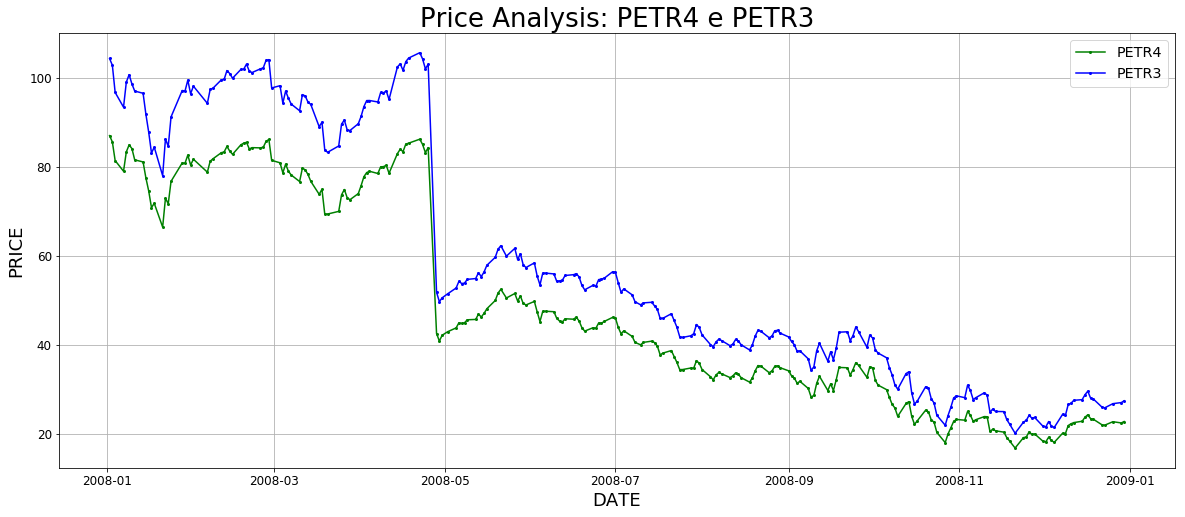

In [80]:
#####################################################################################################
#####################################################################################################
####################### Price Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()
ax.plot(stocks[CONST_date_label], stocks[stock1.option], marker='o', markersize=2, color='green')
ax.plot(stocks[CONST_date_label], stocks[stock2.option], marker='o', markersize=2, color='blue')

fig.set_size_inches(CONST_fig_x, CONST_fig_y)

ax.set_xlabel(CONST_date_label, size=18)
ax.set_ylabel(CONST_price_label, size=18)
ax.set_autoscale_on(True)
ax.set_title("Price Analysis: " + stock1.option + " e " + stock2.option, size=26)
ax.tick_params(labelsize="large")
ax.grid()
ax.legend(fontsize="x-large")

# fig.savefig("test.png")
plt.show()

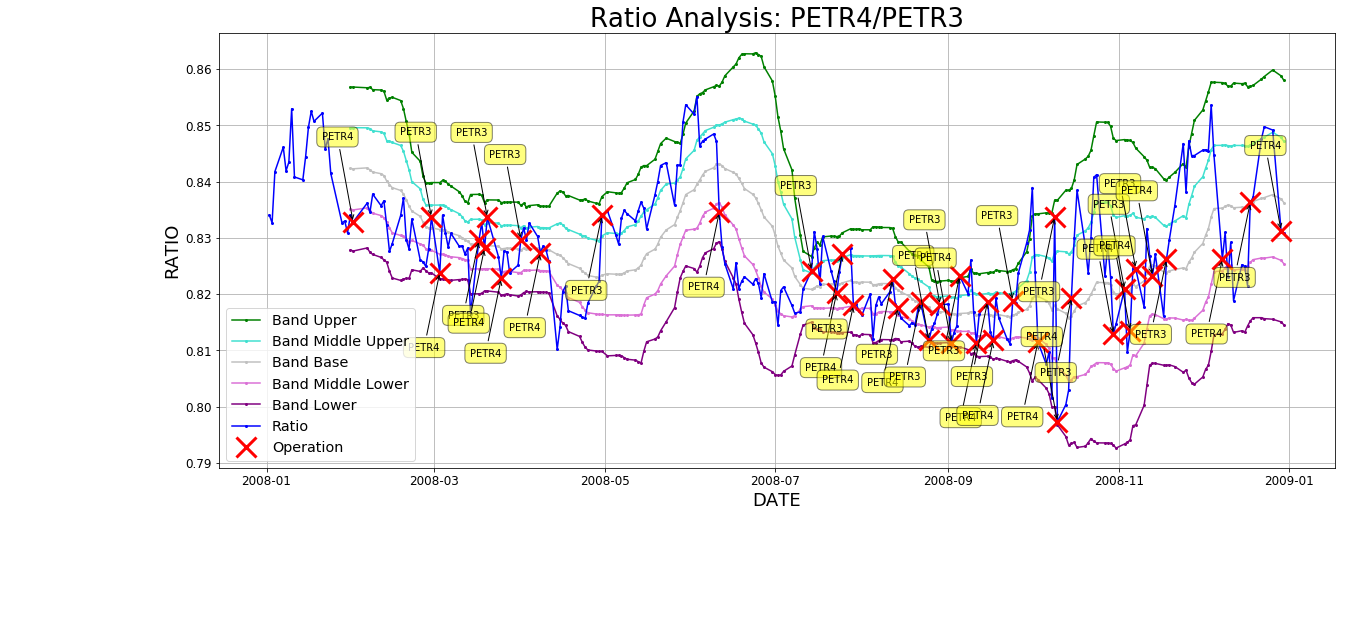

In [70]:
#####################################################################################################
#####################################################################################################
####################### Ratio Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()

ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_upper_label], marker='o', markersize=2, color='green', label='Band Upper')
ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_middleupper_label], marker='o', markersize=2, ls='solid', color='turquoise', label='Band Middle Upper')
ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_base_label], marker='o', markersize=2, color='silver', label='Band Base')
ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_middlelower_label], marker='o', markersize=2, ls='solid', color='orchid', label='Band Middle Lower')
ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_lower_label], marker='o', markersize=2, color='purple', label='Band Lower')
ax.plot(stocks[CONST_date_label], stocks[CONST_ratio_label], marker='o', markersize=2, color='blue', label='Ratio')
ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_result_label], marker='x', ls='None', ms=20, mec='r', mew=3, color='r', label=CONST_operation_label)

fig.set_size_inches(CONST_fig_x, CONST_fig_y)

def get_label(trend, y, stock1, stock2):
        opr = stock1 if trend == -1 else stock2
        return opr #+ "\n" + str(round(label, 2))
    
def get_position(x, y):
    return 0, ((x.toordinal() % 2) * 2 - 1) * 80

for rect in ax.lines:
    if rect.get_label() == CONST_operation_label:
        data = rect.get_data()
        xdata = data[0]
        ydata = data[1]
        
        for x, y in zip(xdata, ydata):
            if y:
                plt.annotate(
                    get_label((bbands[bbands[CONST_date_label] == x][CONST_bbands_trend_label]).item(), y, stock1.option, stock2.option),
                    xy=(x, y), 
                    xytext= get_position(x, y),
                    textcoords='offset points', 
                    ha='right', 
                    va='bottom',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                    arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

ax.set_xlabel(CONST_date_label, size=18)
ax.set_ylabel(CONST_ratio_label, size=18)
ax.set_autoscale_on(True)
ax.set_title("Ratio Analysis: " + CONST_formula, size=26)
ax.tick_params(labelsize="large")
ax.grid()
ax.legend(fontsize='x-large')

# fig.savefig("test.png")
plt.show()

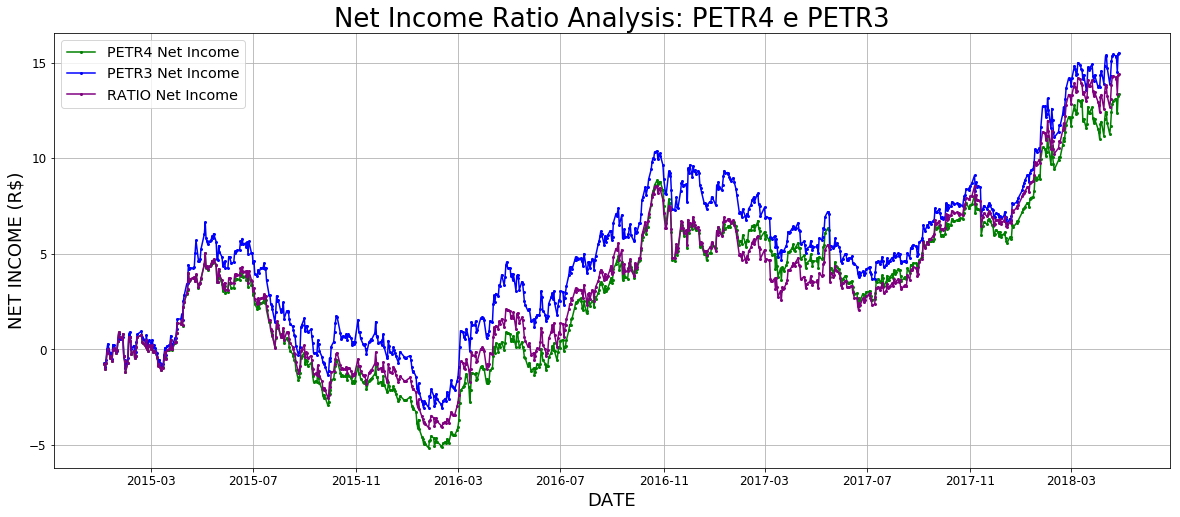

In [10]:
#####################################################################################################
#####################################################################################################
####################### Net Income Ratio Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()
ax.plot(netincome[CONST_date_label], netincome[(netincome_stock1_value_name + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='green', label=(stock1.option + ' Net Income'))
ax.plot(netincome[CONST_date_label], netincome[(netincome_stock2_value_name + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='blue', label=(stock2.option + ' Net Income'))
ax.plot(netincome[CONST_date_label], netincome[(CONST_netincome_ratio_value_label + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='purple', label=(CONST_ratio_label + ' Net Income'))

fig.set_size_inches(CONST_fig_x, CONST_fig_y)

ax.set_xlabel(CONST_date_label, size=18)
ax.set_ylabel("NET INCOME (R$)", size=18)
ax.set_autoscale_on(True)
ax.set_title("Net Income Ratio Analysis: " + stock1.option + " e " + stock2.option, size=26)
ax.tick_params(labelsize="large")
ax.grid()
ax.legend(fontsize='x-large')

# fig.savefig("test.png")
plt.show()

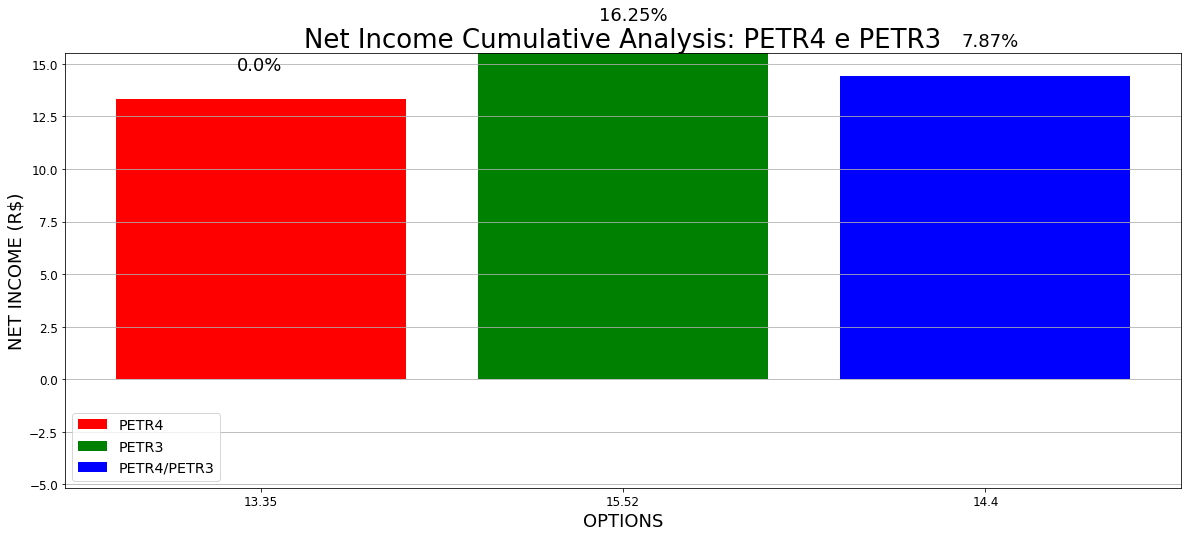

In [11]:
#####################################################################################################
#####################################################################################################
####################### Net Income Cumulative Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()

ind = np.arange(3)
step = ind[1] - ind[0]

values = [
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][netincome_stock1_value_name].sum(),
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][netincome_stock2_value_name].sum(),
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][CONST_netincome_ratio_value_label].sum()    
]

rects = ax.bar(ind, values)

rects[0].set_facecolor('r')
rects[1].set_facecolor('g')
rects[2].set_facecolor('b')

ymin = min(
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][(netincome_stock1_value_name + CONST_cumulative_suffix_label)].min(),
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][(netincome_stock2_value_name + CONST_cumulative_suffix_label)].min(),
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][(CONST_netincome_ratio_value_label + CONST_cumulative_suffix_label)].min()
)

ymax = max(
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][(netincome_stock1_value_name + CONST_cumulative_suffix_label)].max(),
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][(netincome_stock2_value_name + CONST_cumulative_suffix_label)].max(),
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][(CONST_netincome_ratio_value_label + CONST_cumulative_suffix_label)].max()
)

ax.set_ylim([ymin, ymax])
ax.set_ylabel('NET INCOME (R$)', size=18)
ax.set_yscale
ax.set_xlabel('OPTIONS', size=18)
ax.set_xticks(ind)
ax.set_xticklabels([round(x, 2) for x in values], size=50)
ax.set_title("Net Income Cumulative Analysis: " + stock1.option + " e " + stock2.option, size=26)
ax.legend((rects[0], rects[1], rects[2]), (stock1.option, stock2.option, CONST_formula), fontsize='x-large')

for rect in rects:
    y = rect.get_height()
    x = rect.get_x()
    text = str(round(((y-min(values))/abs(min(values)))*100, 2)) + "%"
    ax.text(x + step/len(values), 1.1*y, text, fontsize=18)

fig.set_size_inches(CONST_fig_x, CONST_fig_y)
ax.set_autoscale_on(True)
ax.tick_params(labelsize="large")
ax.grid(axis="y")

# fig.savefig("test.png")
plt.show()